# Will have 3 c_e_0: 0.6, 1.0, 1.6; with High Dx

In [37]:
# magic lines that avoid re-start
%load_ext autoreload
%autoreload 2
import pybamm;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp,sqrt;
import matplotlib as mpl; 
fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip/Rio_Code/Fun_P3"))
sys.path.append(str_path_1) 
from Fun_P3 import *
BasicPath = os.path.expanduser("~/EnvPBGEM_ECDrag2/Double_SimSave/Double_Trans/")
Target  = 'Reproduce_Sol_Seg/' 
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target)

In [39]:
# define parameter of double and single 
Para_dict_Same = {
   ################################# Same for single and double:
   "Mesh list":[ [20,10,20,100,30], ],   # Simon uses 30
   "Para_Set":[ "Li2023_ECdrag",],
   "Contact resistance [Ohm]":[6e-3],
   "Model option":[{
      "SEI": "constant",
      "SEI film resistance":"distributed",   
      "SEI porosity change": "true",
      "solvent diffusion": "double spatial consume w refill",
      "electrolyte conductivity": "sol full"  ,
     "contact resistance":"true",  
      },],
   "Initial Neg SOC":[0.8841301667966484,],
   "Initial Pos SOC":[0.23552755074598045,],}
Para_dict_ce_1M = {
   # solvent diffusion parameters:
   "EC initial concentration in electrolyte [mol.m-3]":[5622.86],
   "Initial concentration in electrolyte [mol.m-3]":[1000],
   "EC diffusivity in electrolyte [m2.s-1]":[
      "EC_diffusivity_5E_10"],
   "Lithium ion EC cross diffusivity [m2.s-1]":[0,2.5e-13, 2.5e-12], # 
}
Para_dict_1p0M = {**Para_dict_Same,**Para_dict_ce_1M}
Para_1p0M = []
recursive_scan(Para_1p0M,Para_dict_1p0M, list(Para_dict_1p0M.keys()), {})
print(len(Para_1p0M))

3


In [40]:
##### Initialise Para_0 and model
def RunOne(Para_dd_i,Rate_Dis):
    CyclePack,para_used = Para_init_Dict(Para_dd_i)
    [Mesh_list,model_options] = CyclePack
    model = pybamm.lithium_ion.DFN(options=model_options)
    str_model_options = str(model_options)
    V_max = 4.2;        V_min = 2.5; #Rate_Dis = 3
    if Rate_Dis > 4:
        ts_dis = 0.5
    else: 
        ts_dis = 2
    Exp_1  = pybamm.Experiment(
    [ (
        f"Hold at {V_max} V until C/100",
        f"Discharge at {Rate_Dis} C until {V_min} V ({ts_dis} second period)", 
        )    ] * 1 )  

    c_e = model.variables["Electrolyte concentration [mol.m-3]"]
    c_EC= model.variables["EC concentration [mol.m-3]"]
    T = model.variables["Cell temperature [K]"]
    D_e = para_used["Electrolyte diffusivity [m2.s-1]"]
    D_EC= para_used["EC diffusivity in electrolyte [m2.s-1]"]
    sigma_e = para_used["Electrolyte conductivity [S.m-1]"]
    dLJP_dcEC = para_used["Measured dLJP_dcEC"] # dLJP_Two_Species_dco_Jung2023(x,y,T): # # ~~~~# x: ce; y: co 
    dLJP_dce  = para_used["Measured dLJP_dce"]
    Xi = para_used["EC transference number"]
    model.variables["Electrolyte diffusivity [m2.s-1]"] = D_e(c_e,c_EC, T)
    model.variables["EC diffusivity in electrolyte [m2.s-1]"] = D_EC(c_e,c_EC, T)
    model.variables["Electrolyte conductivity [S.m-1]"] = sigma_e(c_e,c_EC, T)
    model.variables["EC transference number"] = Xi(c_e,c_EC, T)
    model.variables["c(EC) over c(Li+)"] = c_EC / c_e
    model.variables["dLJP_dcEC"] =  dLJP_dcEC(c_e,c_EC, T)
    model.variables["dLJP_dce"] =  dLJP_dce(c_e,c_EC, T)
    # molar mass in Taeho's paper: unit: g/mol
    M_EMC = 104.105; M_EC = 88.062; M_e = 151.905;
    c_EMC = -0.631191*c_EC-0.49232*c_e+9664.2812
    model.variables["c(EMC) [mol.m-3]"] =  c_EMC
    model.variables["EC:EMC wt%"] =  (c_EC*M_EC) / (c_EMC*M_EMC) 
    model.variables["EC:EMC %"] =  c_EC / c_EMC 
    t_0plus = para_used["Cation transference number"]
    model.variables["Cation transference number"] = t_0plus(c_e,c_EC, T)
    var_pts = {
        "x_n": Mesh_list[0],  # negative electrode
        "x_s": Mesh_list[1],  # separator 
        "x_p": Mesh_list[2],  # positive electrode
        "r_n": Mesh_list[3],  # negative particle
        "r_p": Mesh_list[4],  # positive particle
    }
    sim    = pybamm.Simulation(
        model, experiment = Exp_1,
        parameter_values = para_used,
        solver = pybamm.CasadiSolver(return_solution_if_failed_early=True),
        var_pts=var_pts,
        )       
    sol    = sim.solve()
    return sol

Sol_List = []
for i in range(len(Para_1p0M)):
    Sol_List.append(RunOne(Para_1p0M[i],Rate_Dis=2)) 
    para = Para_1p0M[i]
    print("D_EC=",para["EC diffusivity in electrolyte [m2.s-1]"])
    print("D_e,EC=",para["Lithium ion EC cross diffusivity [m2.s-1]"])


D_EC= EC_diffusivity_5E_10
D_e,EC= 0
D_EC= EC_diffusivity_5E_10
D_e,EC= 2.5e-13
D_EC= EC_diffusivity_5E_10
D_e,EC= 2.5e-12


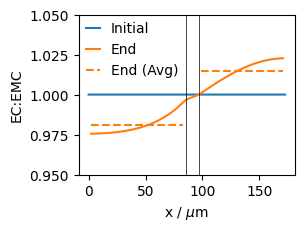

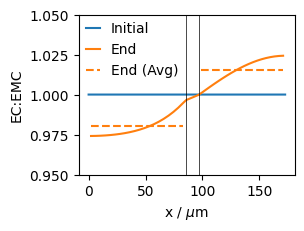

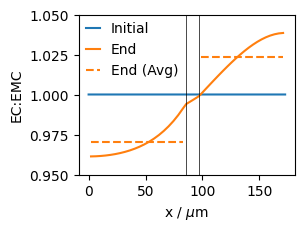

In [41]:
fs = 10; font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
SaveFig = False
Colors = ['#1f77b4','#ff7f0e',  '#d62728', ];
Labels = ["0.6 M","1.0 M","1.6 M"]
def Plot_Sol_Seg(sol):
    step_i  =sol.cycles[0].steps[1]
    Y_0p = np.arange(-1,10,0.1); X_0 = np.arange(0,172.8,0.1)
    fig, axs = plt.subplots( figsize=(8/2.54,6.14/2.54), tight_layout=True) #
    y_ini = step_i["EC:EMC %"].entries[:,0]
    axs.plot( X_0,  np.mean(y_ini[0:20])*np.ones_like(X_0),  Colors[0],label="Initial")
    t_i = (step_i['Time [s]'].entries-step_i['Time [s]'].entries[0]).tolist()
    x =   step_i["x [m]"].entries[:,0]
    x_n =   step_i["x_n [m]"].entries[:,0]
    x_s =   step_i["x_p [m]"].entries[:,0]
    y =   step_i["EC:EMC %"].entries[:,-1]
    y_neg = np.mean(y[0:20]);
    y_pos = np.mean(y[-20:]);
    axs.plot(x*1e6,y,color=Colors[1],label="End") 
    axs.plot(
        x_n*1e6,y_neg* np.ones_like(x_n),
        color=Colors[1],linestyle="--",label="End (Avg)") 
    axs.plot(
        x_s*1e6,y_pos* np.ones_like(x_s),
        color=Colors[1],linestyle="--",) 
    axs.set_xlabel(r"x / $\mu$m",fontdict={'family':'DejaVu Sans','size':fs})
    #axs.set_title(Title_keys[i]) 
    axs.ticklabel_format( 
        axis='x', style='sci',
        scilimits=[-1e3,1e3], useOffset=None, 
        useLocale=None, useMathText=None)

    axs.set_ylabel("EC:EMC")
    axs.plot( 85.2 * np.ones_like(Y_0p),Y_0p,"k-",linewidth=0.5,)
    axs.plot((85.2+12 )* np.ones_like(Y_0p),Y_0p, "k-",linewidth=0.5,)
    axs.legend(
        prop={'family':'DejaVu Sans','size':fs},
        markerscale=0.5,borderpad=0.0,
        handlelength=1.0,loc='best',frameon=False)  
    axs.set_ylim([0.95,1.05])
    # fig.suptitle(f"3C Discharge, t={round(t_select)} s", fontsize=fs+1)

    if SaveFig == True:
        plt.savefig(BasicPath +  Target+ f"2C_1M_EC_EMC_%.png", dpi=600)
        plt.savefig(BasicPath +  Target+ f"2C_1M_EC_EMC_%.svg")   
    return

Plot_Sol_Seg(Sol_List[0])
Plot_Sol_Seg(Sol_List[1])
Plot_Sol_Seg(Sol_List[2])


In [ ]:
print(y_neg,y_pos)
print(y[0],y[-1])

0.6451567125647512 1.3649713240773473
0.5302836335437592 1.5649595792147706


In [ ]:
print(0.15*np.array([9778 , 1.4631, 0.3589]))
1- 2.19465e-01

[1.46670e+03 2.19465e-01 5.38350e-02]


0.780535